# ML_Project.ipynb
Proyek klasifikasi Rice Cammeo & Osmancik

## 1. Import Library

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
import time

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

## 2. Import Source Code

In [272]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('..').resolve()))

from src.load_data import load_rice
from src.preprocess import preprocess
from src.train_baseline import train_baseline
from src.train_advanced import train_rf
from src.train_deep_learning import train_mlp
from src.eda_histogram import plot_histograms
from src.eda_heatmap import plot_correlation_heatmap
from src.eda_class_distribution import plot_class_distribution
from src.evaluate import evaluate_sklearn, evaluate_mlp


## 3. Load Dataset

In [273]:
DATA_PATH = "../data/Rice_Cammeo_Osmancik.arff"

# Load dataset dari file ARFF
df = load_rice(DATA_PATH)

# Memisahkan fitur dan label
X = df.drop('Class', axis=1)
y = df['Class']

# Mengecek dimensi data dan distribusi kelas
print(X.shape)
print(y.value_counts())
df.head()


(3810, 7)
Class
Osmancik    2180
Cammeo      1630
Name: count, dtype: int64


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,Cammeo
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,Cammeo
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,Cammeo
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,Cammeo
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,Cammeo


## 4. Dataset Understanding

In [274]:
# Membuat tabel deskripsi fitur untuk dokumentasi dataset
feature_info = pd.DataFrame({
    "Nama Fitur": X.columns,
    "Tipe Data": X.dtypes.values,
    "Deskripsi": [
        "Luas area butir beras",
        "Keliling butir beras",
        "Panjang sumbu utama",
        "Panjang sumbu minor",
        "Tingkat kelonjongan butir",
        "Luas area konveks",
        "Rasio luas area terhadap bounding box"
    ],
    "Contoh Nilai": [X[col].iloc[0] for col in X.columns]
})

feature_info


,Nama Fitur,Tipe Data,Deskripsi,Contoh Nilai
0,Area,float64,Luas area butir beras,15231.000000
1,Perimeter,float64,Keliling butir beras,525.578979
2,Major_Axis_Length,float64,Panjang sumbu utama,229.749878
3,Minor_Axis_Length,float64,Panjang sumbu minor,85.093788
4,Eccentricity,float64,Tingkat kelonjongan butir,0.928882
5,Convex_Area,float64,Luas area konveks,15617.000000
6,Extent,float64,Rasio luas area terhadap bounding box,0.572896


In [275]:
# Mengecek persentase missing values pada setiap fitur
(X.isnull().mean() * 100).round(2)


Area                 0.0
Perimeter            0.0
Major_Axis_Length    0.0
Minor_Axis_Length    0.0
Eccentricity         0.0
Convex_Area          0.0
Extent               0.0
dtype: float64

In [276]:
# Mengecek jumlah data duplikat (fitur + label)
pd.concat([X, y], axis=1).duplicated().sum()


np.int64(0)

In [277]:
# Deteksi outlier menggunakan metode IQR
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).sum()
outliers



Area                  4
Perimeter             0
Major_Axis_Length     0
Minor_Axis_Length    65
Eccentricity         21
Convex_Area           3
Extent                0
dtype: int64

In [278]:
# Mengecek distribusi kelas dalam persentase
(y.value_counts(normalize=True) * 100).round(2)


Class
Osmancik    57.22
Cammeo      42.78
Name: proportion, dtype: float64

## 5. EDA

In [279]:
# Visualisasi distribusi fitur numerik
plot_histograms(X)


<Figure size 1200x1000 with 0 Axes>

In [280]:
# Visualisasi korelasi antar fitur
plot_correlation_heatmap(X)

In [281]:
# Visualisasi distribusi kelas
plot_class_distribution(y)

## 6. Preprocessing

In [282]:
# Preprocessing: encoding label, scaling fitur, dan splitting data
X_train, X_test, y_train, y_test, scaler, label_encoder = preprocess(X, y)

# Validasi hasil preprocessing
print(X_train.shape, X_test.shape)
print(X_train.dtype)
print(y_train.dtype)
print(type(y_train))

print(pd.DataFrame(X_train[:5], columns=X.columns))
print(pd.Series(y_train[:5]))


(3048, 7) (762, 7)
float32
float32
<class 'numpy.ndarray'>
       Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  0.236859  -0.035069          -0.274971           0.938418     -0.956396   
1  1.566428   1.386246           1.324475           1.221141      0.525580   
2 -0.801163  -0.959142          -1.037800          -0.142498     -1.027842   
3 -0.149946   0.004265           0.178851          -0.572567      0.704681   
4  0.844777   1.024427           1.040355           0.343913      0.843102   

   Convex_Area    Extent  
0     0.243425  0.916876  
1     1.573953  1.015056  
2    -0.771355 -0.242905  
3    -0.162374 -1.010353  
4     0.881673  1.178274  
0    1.0
1    0.0
2    1.0
3    1.0
4    0.0
dtype: float32


## 7. Model 1: Baseline

In [283]:
# Training Logistic Regression sebagai baseline model
start = time.time()
model_lr = train_baseline(X_train, y_train)
train_lr_time = time.time() - start


In [285]:
# Evaluasi performa Logistic Regression
model_lr = joblib.load("../models/model_baseline.pkl")
start = time.time()
y_pred_lr = model_lr.predict(X_test)
inference_lr = time.time() - start

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, average="weighted")
rec_lr = recall_score(y_test, y_pred_lr, average="weighted")
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.916010498687664
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       326
         1.0       0.92      0.94      0.93       436

    accuracy                           0.92       762
   macro avg       0.92      0.91      0.91       762
weighted avg       0.92      0.92      0.92       762



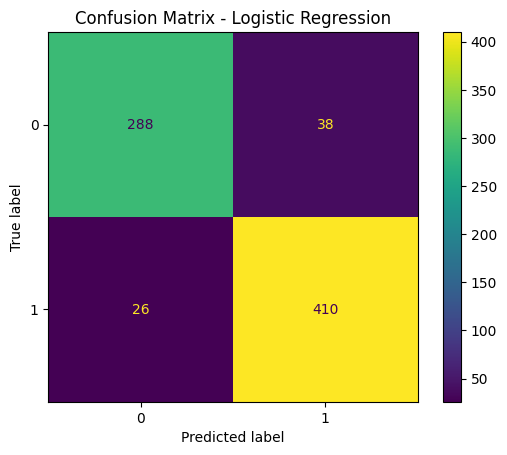

In [286]:
# Confusion Matrix untuk Logistic Regression
cm = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()



## 8. Model 2: Anvanced

In [287]:
# Training Random Forest sebagai model lanjutan
start = time.time()
model_rf = train_rf(X_train, y_train)
train_rf_time = time.time() - start



In [288]:
# Evaluasi performa Random Forest
model_rf = joblib.load("../models/model_rf.pkl")
start = time.time()
y_pred_rf = model_rf.predict(X_test)
inference_rf = time.time() - start

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average="weighted")
rec_rf = recall_score(y_test, y_pred_rf, average="weighted")
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.9186351706036745
              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90       326
         1.0       0.91      0.95      0.93       436

    accuracy                           0.92       762
   macro avg       0.92      0.91      0.92       762
weighted avg       0.92      0.92      0.92       762



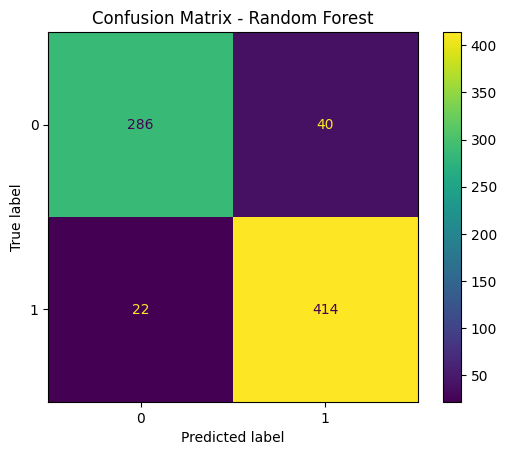

In [289]:
# Confusion Matrix untuk Random Forest
cm = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()


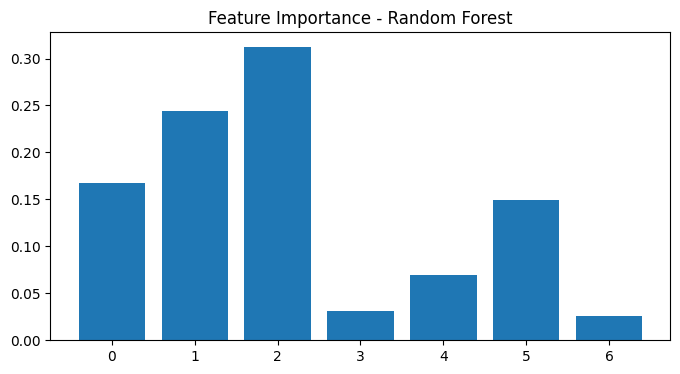

In [290]:
# Visualisasi feature importance dari Random Forest
importances = model_rf.feature_importances_

plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance - Random Forest")
plt.show()


## 9. Model 3: Deep Learning

In [291]:
# Training model Deep Learning (MLP)
start = time.time()
model_mlp, history = train_mlp(X_train, y_train)
train_mlp_time = time.time() - start



Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8934 - loss: 0.2910 - val_accuracy: 0.9180 - val_loss: 0.2227
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9319 - loss: 0.1785 - val_accuracy: 0.9164 - val_loss: 0.2253
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9348 - loss: 0.1757 - val_accuracy: 0.9164 - val_loss: 0.2253
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9356 - loss: 0.1746 - val_accuracy: 0.9148 - val_loss: 0.2245
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9348 - loss: 0.1767 - val_accuracy: 0.9164 - val_loss: 0.2258
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9356 - loss: 0.1724 - val_accuracy: 0.9148 - val_loss: 0.2252
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9348 - loss: 0.1739 - val_accuracy: 0.9180 - val_loss: 0.2211
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9352 - loss: 0.1767 - val_accuracy: 0.9164 - val_loss

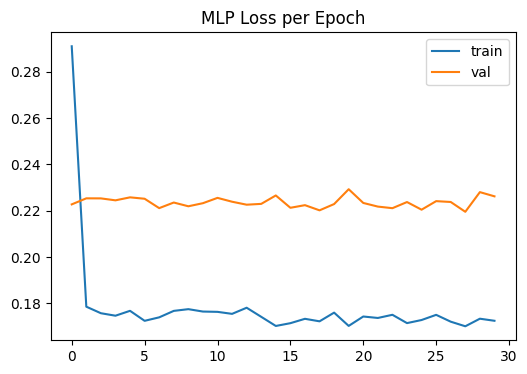

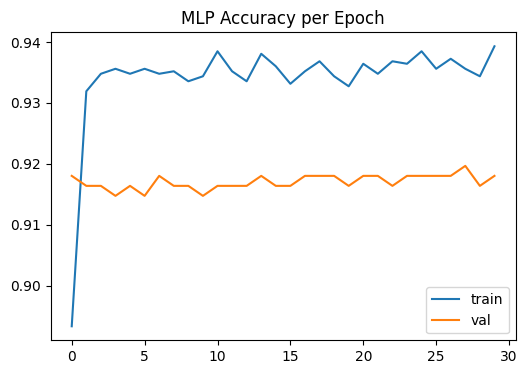

In [292]:
# Visualisasi loss selama training MLP
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("MLP Loss per Epoch")
plt.legend()
plt.show()

# Visualisasi akurasi selama training MLP
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("MLP Accuracy per Epoch")
plt.legend()
plt.show()



In [293]:
# Evaluasi performa MLP pada data test
model_mlp = tf.keras.models.load_model("../models/model_mlp.h5")
start = time.time()
y_pred_mlp = (model_mlp.predict(X_test) > 0.5).astype(int)
inference_mlp = time.time() - start

acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp, average="weighted")
rec_mlp = recall_score(y_test, y_pred_mlp, average="weighted")
f1_mlp = f1_score(y_test, y_pred_mlp, average="weighted")

print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9146981627296588
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90       326
         1.0       0.91      0.94      0.93       436

    accuracy                           0.91       762
   macro avg       0.92      0.91      0.91       762
weighted avg       0.91      0.91      0.91       762



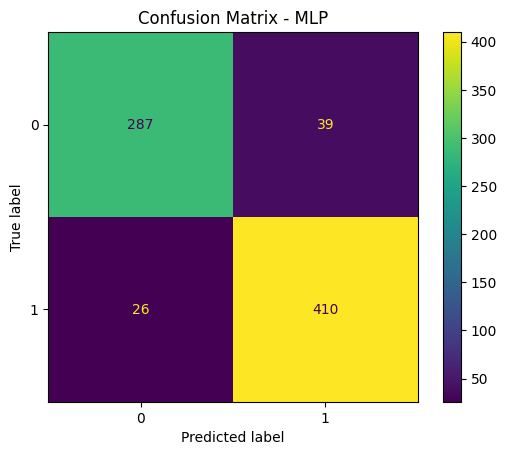

In [294]:
# Confusion Matrix untuk MLP
cm = confusion_matrix(y_test, y_pred_mlp)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - MLP")
plt.show()


In [295]:
# Menampilkan ringkasan arsitektur model MLP
model_mlp.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,347 (36.52 KB)

 Trainable params: 9,345 (36.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## 10. Perbandingan Model

In [296]:
# Tabel perbandingan performa antar model
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "MLP"],
    "Accuracy": [acc_lr, acc_rf, acc_mlp],
    "Precision": [prec_lr, prec_rf, prec_mlp],
    "Recall": [rec_lr, rec_rf, rec_mlp],
    "F1-Score": [f1_lr, f1_rf, f1_mlp],
    "Training Time (s)": [train_lr_time, train_rf_time, train_mlp_time],
    "Inference Time (s)": [inference_lr, inference_rf, inference_mlp]
})

comparison




,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Inference Time (s)
0,Logistic Regression,0.916010,0.916042,0.916010,0.915793,0.164704,0.002026
1,Random Forest,0.918635,0.919029,0.918635,0.918303,1.622016,0.028608
2,MLP,0.914698,0.914763,0.914698,0.914457,14.101936,0.230973


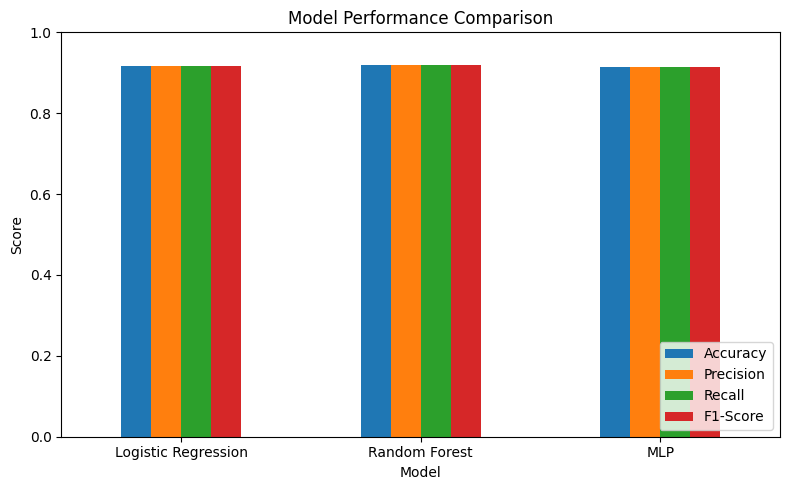

In [297]:
# Visualisasi perbandingan metrik performa model
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
comparison.set_index("Model")[metrics].plot(
    kind="bar",
    figsize=(8,5)
)

plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()





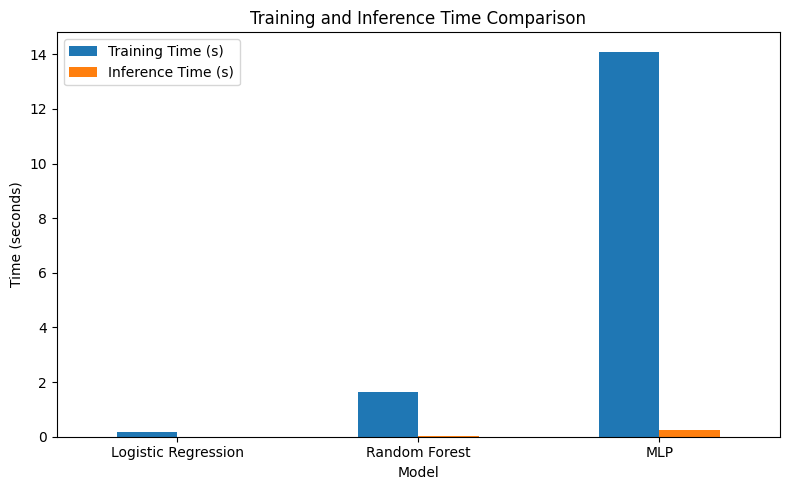

In [298]:
# Visualisasi perbandingan waktu training dan inference
comparison.set_index("Model")[["Training Time (s)", "Inference Time (s)"]].plot(
    kind="bar",
    figsize=(8,5)
)

plt.title("Training and Inference Time Comparison")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

